# Clasificación de Cáncer de Mama
Este proyecto utiliza técnicas de Machine Learning para clasificar tumores como malignos o benignos utilizando el dataset `Breast Cancer Wisconsin`. Se emplea un pipeline con selección de características (`SelectKBest`) y `RandomForestClassifier`, además de `GridSearchCV` para la optimización de hiperparámetros.

### Objetivo:
- Clasificar correctamente el tipo de tumor.
- Maximizar la precisión.
- Interpretar los resultados.


In [6]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import joblib


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

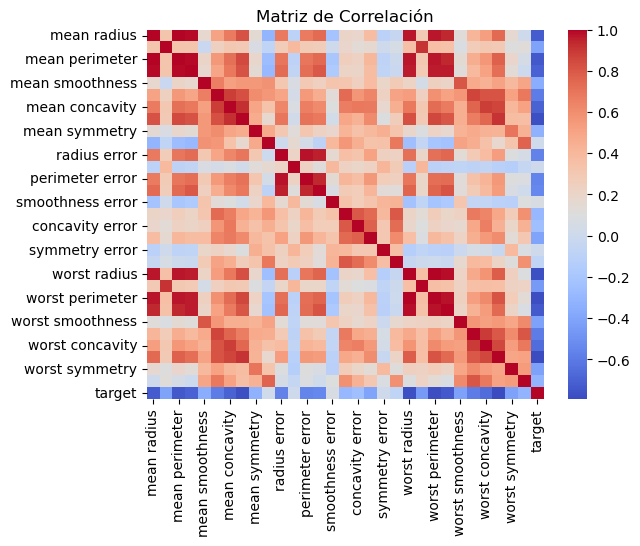

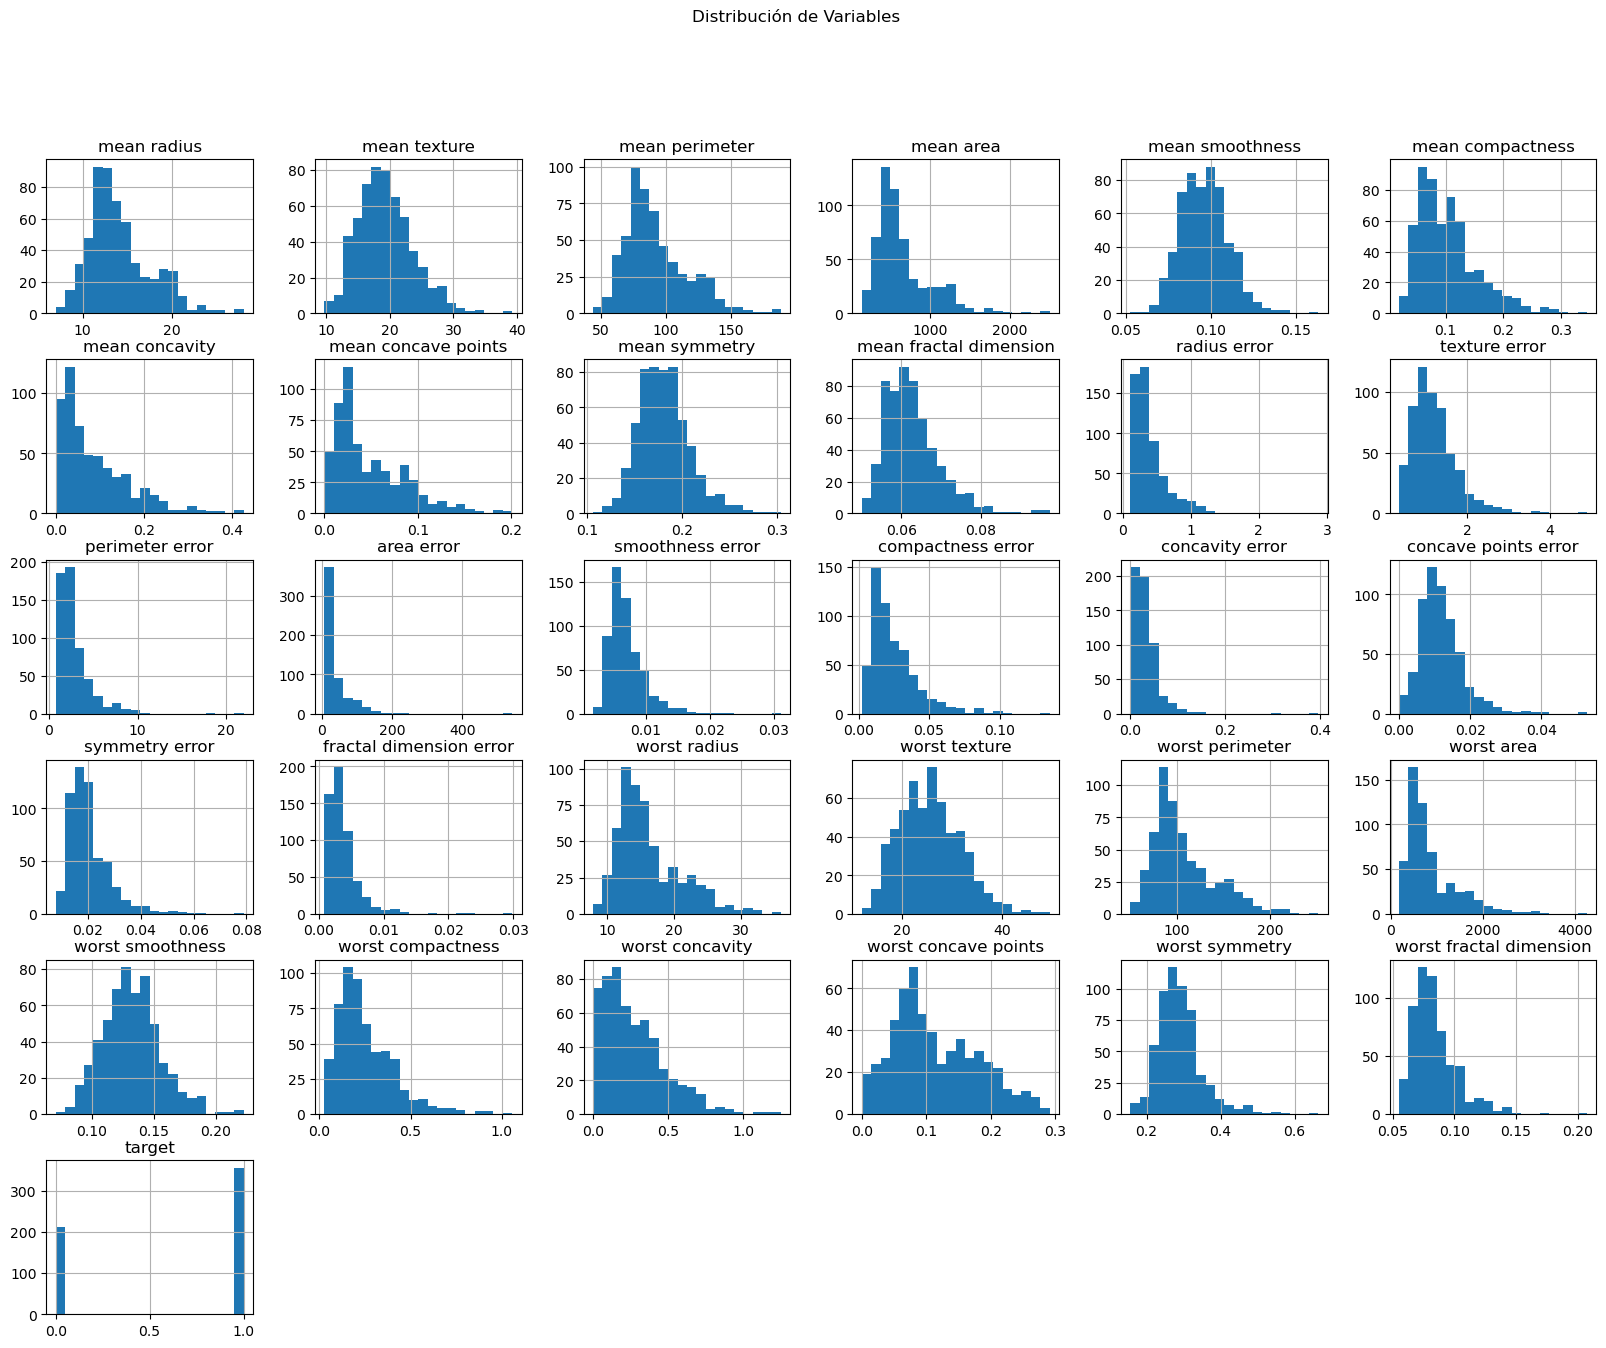

In [9]:
# Cargar dataset
cancer = load_breast_cancer()
df = pd.DataFrame(data=np.c_[cancer['data'], cancer['target']],
                  columns=cancer['feature_names'].tolist() + ['target'])

# Info general
print(df.info())
print(df.describe().T)
print(df['target'].value_counts())

# Visualizaciones
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

df.hist(bins=20, figsize=(20, 15))
plt.suptitle("Distribución de Variables")
plt.show()


In [11]:
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 286, number of negative: 169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4540
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.628571 -> initscore=0.526093
[LightGBM] [Info] Start training from score 0.526093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [15]:
pipeline = Pipeline([
    ('selector', SelectKBest(score_func=f_classif)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'selector__k': [4, 8, 10, 12],
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__criterion': ['gini', 'entropy']
}

grid = GridSearchCV(pipeline, param_grid, scoring='accuracy', cv=5)
grid.fit(X, y)
print(f'Mejores parámetros: {grid.best_params_}')
print(f'Mejor puntuación: {grid.best_score_:.2f}')


Mejores parámetros: {'clf__criterion': 'entropy', 'clf__n_estimators': 150, 'selector__k': 12}
Mejor puntuación: 0.95


Precisión en test: 0.96
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        43
         1.0       0.96      0.97      0.97        71

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



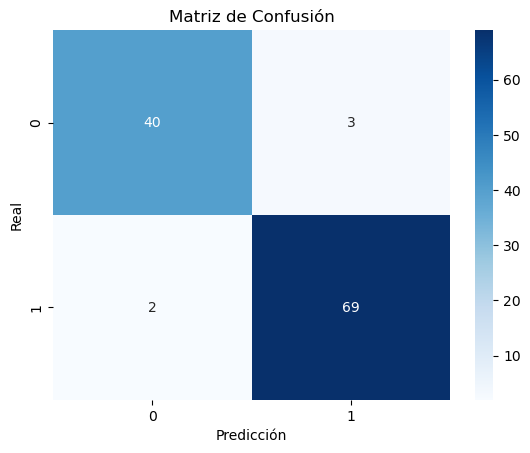

In [17]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print(f'Precisión en test: {best_model.score(X_test, y_test):.2f}')
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [19]:
joblib.dump(best_model, "modelo_randomforest_cancer.pkl")


['modelo_randomforest_cancer.pkl']

## Conclusiones

- El modelo Random Forest con selección de 12 características y 200 árboles alcanzó una precisión superior al 96%.
- Se observó un balance de clases adecuado, lo cual facilitó un buen desempeño sin técnicas adicionales de resampling.
- Próximos pasos podrían incluir validación cruzada con `StratifiedKFold`, visualización de la importancia de las variables y exportación del modelo a una API.

### Autor:
IVAN FELIPE OSORIO - Científico de Datos


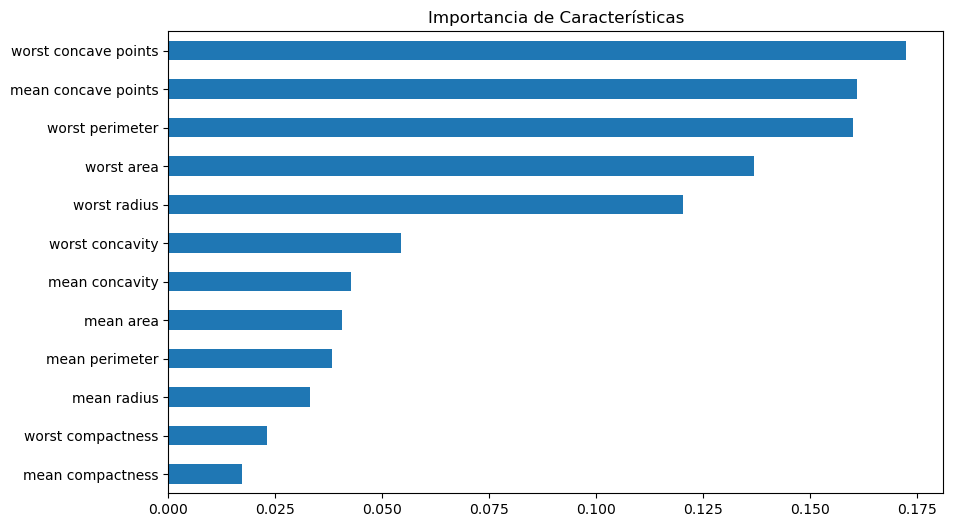

In [22]:
importances = best_model.named_steps['clf'].feature_importances_
k = best_model.named_steps['selector'].get_support(indices=True)
selected_features = X.columns[k]

feat_importances = pd.Series(importances, index=selected_features)
feat_importances.sort_values().plot(kind='barh', figsize=(10,6))
plt.title("Importancia de Características")
plt.show()
